<a href="https://colab.research.google.com/github/huyhuy382003/Apple_stocks_predict/blob/main/Apple_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import yfinance as yf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, avg
from pyspark.sql.window import Window

#Define start day to fetch the dataset from the yahoo finance library

In [3]:
# Tạo Spark session
spark = SparkSession.builder.appName("StockDataProcessing").getOrCreate()

# Thiết lập thời gian tải dữ liệu
START = "2015-01-01"
END = "2025-01-01"

In [4]:
# Hàm tải dữ liệu từ Yahoo Finance
def load_data(ticker):
    data = yf.download(ticker, START, END)
    data.reset_index(inplace=True)
    return data

In [5]:
# Bước 1: Tải dữ liệu từ Yahoo Finance
df = load_data("AAPL")

# ✅ Xử lý tên cột: xoá multi-level index
df.columns = [col if not isinstance(col, tuple) else col[0] for col in df.columns]

# ✅ In lại tên cột để kiểm tra
print(df.columns)

# Bước 2: Tạo Spark DataFrame từ Pandas
df_spark = spark.createDataFrame(df)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


Schema:
root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: double (nullable = true)


First 5 rows:
+----------+------------------+------------------+------------------+------------------+----------+
|Date      |Open              |High              |Low               |Close             |Volume    |
+----------+------------------+------------------+------------------+------------------+----------+
|2015-01-02|24.74623350688034 |24.757342109103483|23.84871302414892 |24.28858757019043 |2.128184E8|
|2015-01-05|24.057537291404817|24.137514464137663|23.41772160447641 |23.604333877563477|2.57142E8 |
|2015-01-06|23.668756205006424|23.86647704595982 |23.24443284626176 |23.606552124023438|2.631884E8|
|2015-01-07|23.81538275875591 |24.037541186337343|23.704303544965192|23.937570571899414|1.604236E8|
|2015-01-08|24.26635942373162 |24.915061455285365|24.14

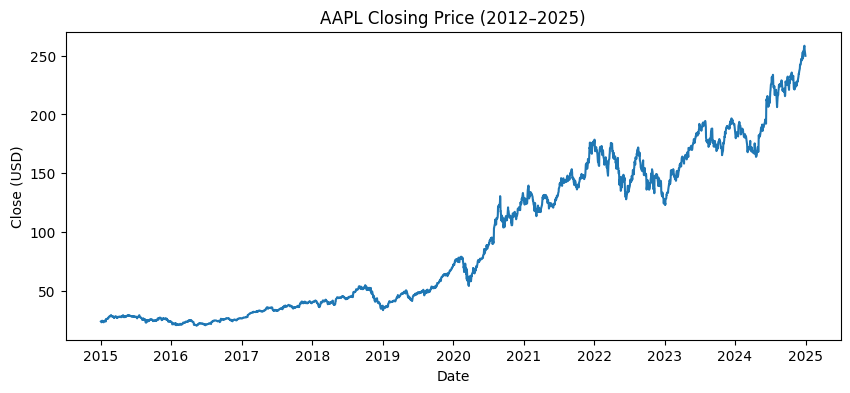

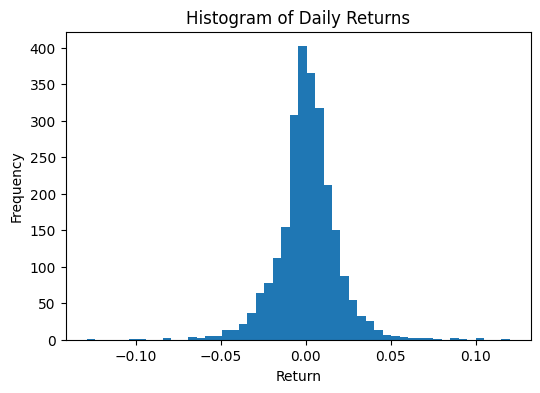

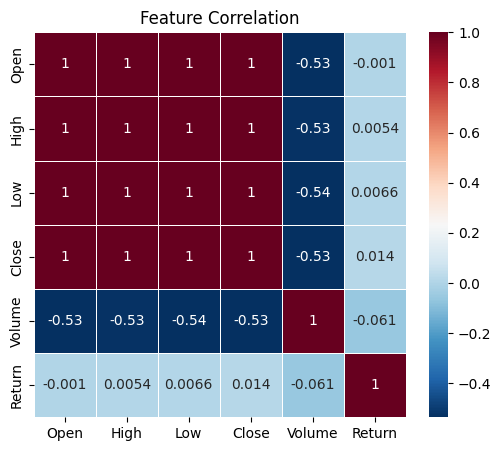

In [6]:
# ── Cell 3: PySpark EDA on AAPL (fixed) ─────────────────────────
import yfinance as yf
import pandas as pd
from pyspark.sql.functions import to_date, col
from pyspark.sql.types import DoubleType


# 2) Flatten MultiIndex columns if present
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

# 3) Keep only needed columns
pdf = df[["Date", "Open", "High", "Low", "Close", "Volume"]]

# 4) Spark DataFrame + cast types
sdf = spark.createDataFrame(pdf)
for c in ["Open", "High", "Low", "Close", "Volume"]:
    sdf = sdf.withColumn(c, col(c).cast(DoubleType()))
sdf = sdf.withColumn("Date", to_date(col("Date"), "yyyy-MM-dd"))

# ── EDA ───────────────────────────────────────────────────────────
# a) Schema & sample
print("Schema:")
sdf.printSchema()
print("\nFirst 5 rows:")
sdf.show(5, truncate=False)

# b) Summary statistics
desc = sdf.describe().toPandas().set_index("summary").T
print("\nSummary Statistics:")
print(desc)

# c) Convert to pandas for plotting
pdf2 = sdf.orderBy("Date").toPandas()
pdf2["Return"] = pdf2["Close"].pct_change()

import matplotlib.pyplot as plt
import seaborn as sb

# d) Closing price over time
plt.figure(figsize=(10,4))
plt.plot(pdf2["Date"], pdf2["Close"], label="Close")
plt.title("AAPL Closing Price (2012–2025)")
plt.xlabel("Date"); plt.ylabel("Close (USD)")
plt.show()

# e) Histogram of daily returns
plt.figure(figsize=(6,4))
plt.hist(pdf2["Return"].dropna(), bins=50)
plt.title("Histogram of Daily Returns")
plt.xlabel("Return"); plt.ylabel("Frequency")
plt.show()

# f) Correlation heatmap
corr = pdf2[["Open","High","Low","Close","Volume","Return"]].corr()
plt.figure(figsize=(6,5))
sb.heatmap(corr, annot=True, cmap="RdBu_r", linewidths=0.5)
plt.title("Feature Correlation")
plt.show()


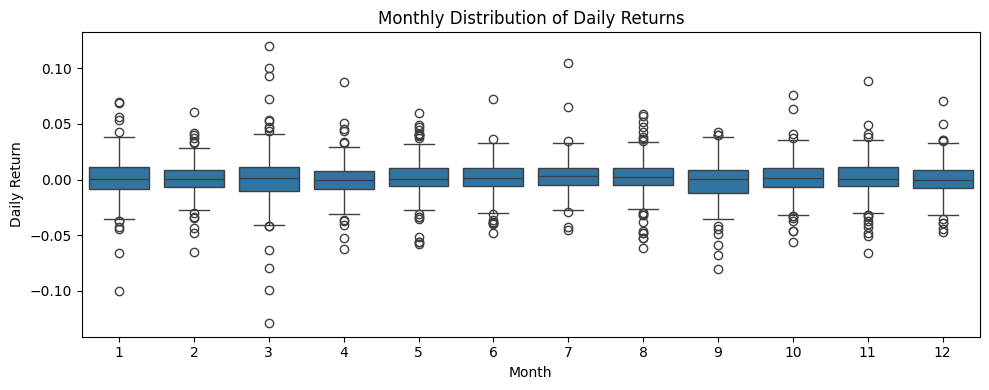

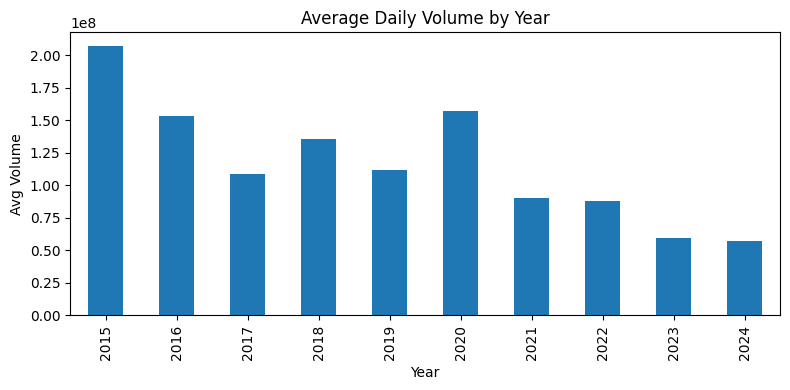

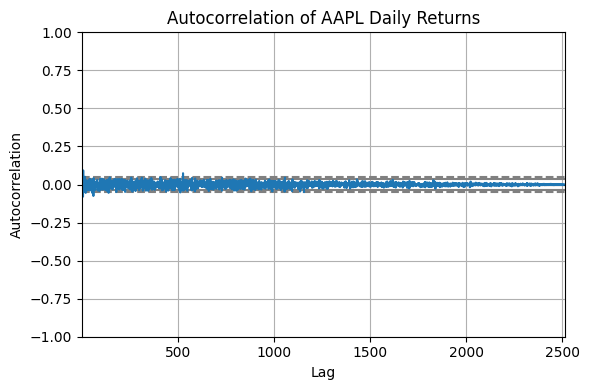

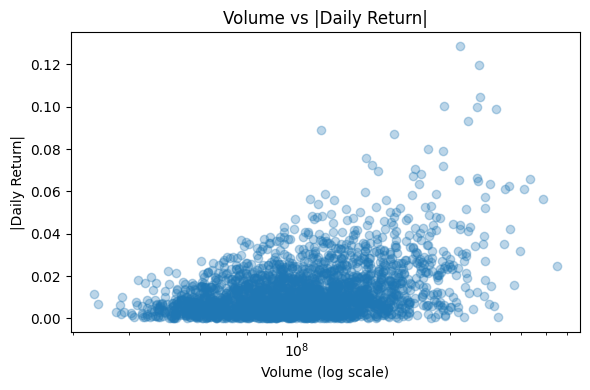

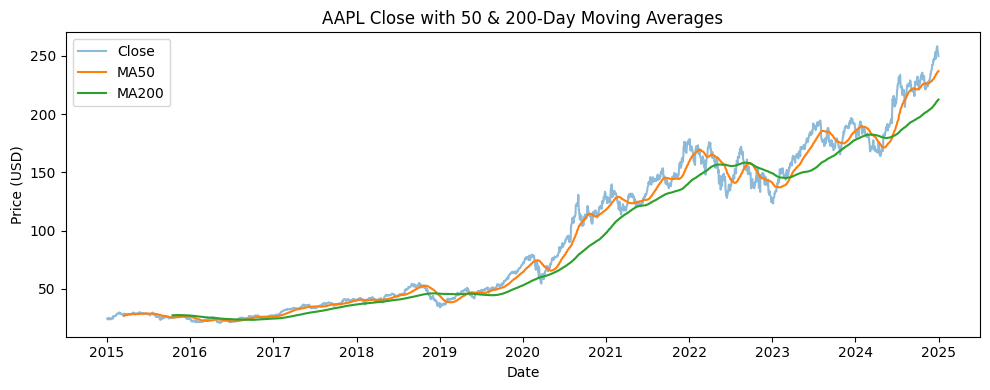

In [7]:
# 2) Prepare features
df['Return'] = df['Close'].pct_change()
df['Year']   = df['Date'].dt.year
df['Month']  = df['Date'].dt.month

# A) Boxplot of daily returns by month
plt.figure(figsize=(10,4))
sb.boxplot(x='Month', y='Return', data=df)
plt.title("Monthly Distribution of Daily Returns")
plt.xlabel("Month")
plt.ylabel("Daily Return")
plt.tight_layout()
plt.show()

# B) Average volume by year (bar chart)
vol_year = df.groupby('Year')['Volume'].mean()
plt.figure(figsize=(8,4))
vol_year.plot(kind='bar')
plt.title("Average Daily Volume by Year")
plt.xlabel("Year")
plt.ylabel("Avg Volume")
plt.tight_layout()
plt.show()

# C) Autocorrelation of daily returns
plt.figure(figsize=(6,4))
pd.plotting.autocorrelation_plot(df['Return'].dropna())
plt.title("Autocorrelation of AAPL Daily Returns")
plt.tight_layout()
plt.show()

# D) Scatter: Volume vs Absolute Return
plt.figure(figsize=(6,4))
plt.scatter(df['Volume'], df['Return'].abs(), alpha=0.3)
plt.xscale('log')
plt.title("Volume vs |Daily Return|")
plt.xlabel("Volume (log scale)")
plt.ylabel("|Daily Return|")
plt.tight_layout()
plt.show()

# E) Moving averages crossover
df['MA50']  = df['Close'].rolling(50).mean()
df['MA200'] = df['Close'].rolling(200).mean()
plt.figure(figsize=(10,4))
plt.plot(df['Date'], df['Close'], label='Close', alpha=0.5)
plt.plot(df['Date'], df['MA50'],  label='MA50')
plt.plot(df['Date'], df['MA200'], label='MA200')
plt.title("AAPL Close with 50 & 200-Day Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()


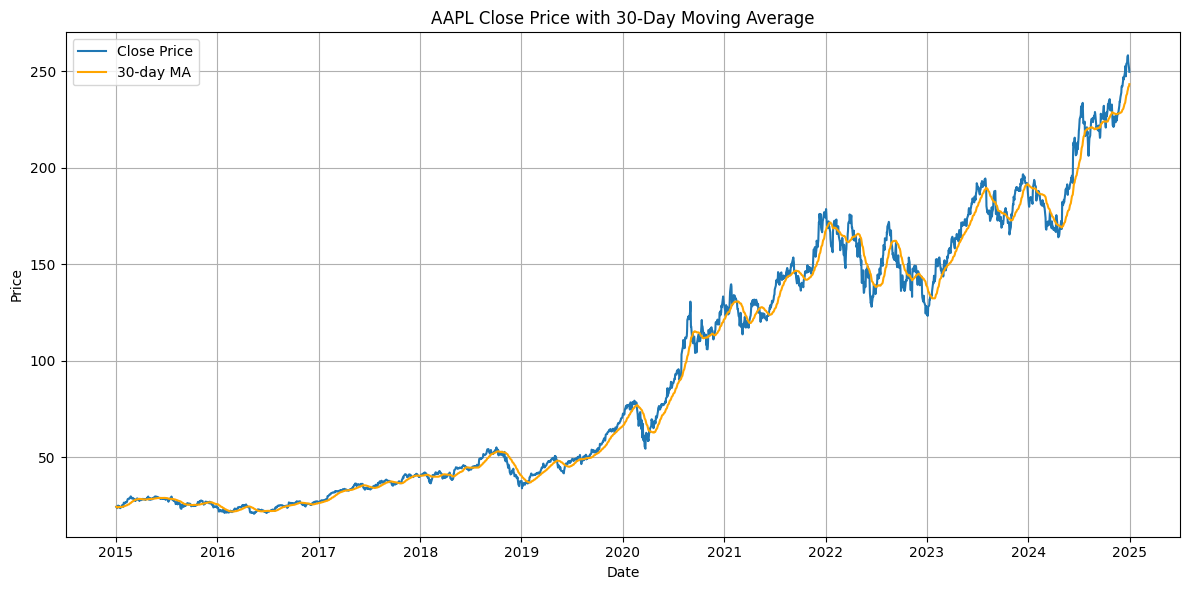

In [8]:
from pyspark.sql.functions import col, to_date, avg
from pyspark.sql.window import Window

# Đảm bảo cột 'Date' là kiểu ngày
df_spark = df_spark.withColumn("Date", to_date(col("Date")))

# Giữ lại các cột cần thiết
df_spark = df_spark.select("Date", "Close")

# Tính MA 30 ngày
windowSpec = Window.orderBy("Date").rowsBetween(-29, 0)
df_spark = df_spark.withColumn("MA_30", avg("Close").over(windowSpec))

# Sắp xếp theo ngày
df_spark = df_spark.orderBy("Date")

# Chuyển về Pandas để vẽ
df_plot = df_spark.toPandas()

# Vẽ biểu đồ
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(df_plot["Date"], df_plot["Close"], label="Close Price")
plt.plot(df_plot["Date"], df_plot["MA_30"], label="30-day MA", color="orange")
plt.title("AAPL Close Price with 30-Day Moving Average")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
from pyspark.sql.functions import lag, when, lit
from pyspark.sql.window import Window

# Thêm cột change = Close - Close của ngày trước
windowSpec_lag = Window.orderBy("Date")
df_spark = df_spark.withColumn("prev_Close", lag("Close").over(windowSpec_lag))
df_spark = df_spark.withColumn("change", col("Close") - col("prev_Close"))

# Tính gain và loss
df_spark = df_spark.withColumn("gain", when(col("change") > 0, col("change")).otherwise(lit(0.0)))
df_spark = df_spark.withColumn("loss", when(col("change") < 0, -col("change")).otherwise(lit(0.0)))

# Cửa sổ 14 ngày để tính trung bình gain và loss
windowSpec_rsi = Window.orderBy("Date").rowsBetween(-13, 0)

df_spark = df_spark.withColumn("avg_gain", avg("gain").over(windowSpec_rsi))
df_spark = df_spark.withColumn("avg_loss", avg("loss").over(windowSpec_rsi))

# Tính RSI
df_spark = df_spark.withColumn(
    "RSI_14",
    when(col("avg_loss") == 0, lit(100))
    .otherwise(100 - (100 / (1 + col("avg_gain") / col("avg_loss"))))
)


In [10]:
df_spark.select("Date", "Close", "MA_30", "RSI_14").orderBy("Date").show(20)


+----------+------------------+------------------+------------------+
|      Date|             Close|             MA_30|            RSI_14|
+----------+------------------+------------------+------------------+
|2015-01-02| 24.28858757019043| 24.28858757019043|             100.0|
|2015-01-05|23.604333877563477|23.946460723876953|               0.0|
|2015-01-06|23.606552124023438|23.833157857259113| 0.323137237468373|
|2015-01-07|23.937570571899414| 23.85926103591919|32.750844490100434|
|2015-01-08|  24.8572998046875| 24.05886878967285| 64.67856893195662|
|2015-01-09|24.883968353271484|24.196385383605957| 65.15821503181199|
|2015-01-12|24.270803451538086| 24.20701653616769|  49.6549524171834|
|2015-01-13| 24.48630714416504| 24.24192786216736| 53.54011736871152|
|2015-01-14|24.392993927001953|24.258712980482315| 51.80892343626386|
|2015-01-15|23.730966567993164|  24.2059383392334| 42.14152850353741|
|2015-01-16| 23.54657554626465|24.145996267145332|40.059556601256965|
|2015-01-20|24.15306

In [11]:
df_plot = df_spark.select("Date", "Close", "MA_30", "RSI_14").orderBy("Date").toPandas()


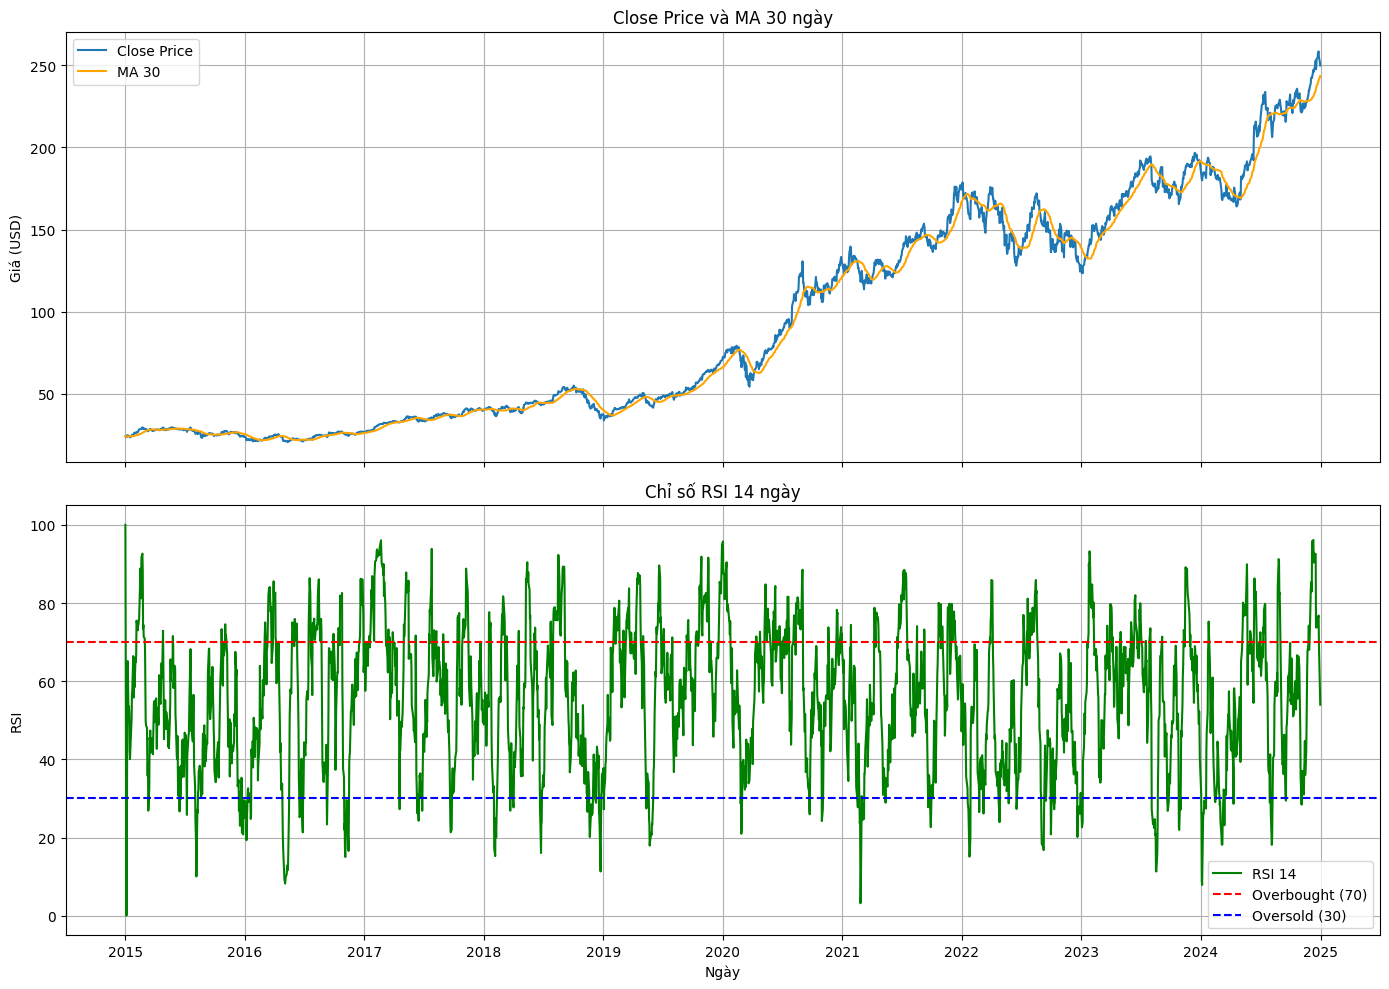

In [12]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Biểu đồ giá Close và MA_30
ax1.plot(df_plot["Date"], df_plot["Close"], label="Close Price")
ax1.plot(df_plot["Date"], df_plot["MA_30"], label="MA 30", color="orange")
ax1.set_title("Close Price và MA 30 ngày")
ax1.set_ylabel("Giá (USD)")
ax1.legend()
ax1.grid(True)

# Biểu đồ RSI 14 ngày
ax2.plot(df_plot["Date"], df_plot["RSI_14"], label="RSI 14", color="green")
ax2.axhline(70, color='red', linestyle='--', label='Overbought (70)')
ax2.axhline(30, color='blue', linestyle='--', label='Oversold (30)')
ax2.set_title("Chỉ số RSI 14 ngày")
ax2.set_ylabel("RSI")
ax2.set_xlabel("Ngày")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()



# Training the model


In [13]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential # Import the Sequential model
from tensorflow.keras.layers import LSTM, Dense, Dropout # Import necessary layers


# df_plot is assumed to have columns: Date, Close, MA_30, RSI_14

# Extract the 'Close' column for prediction
data = df_plot[["Close"]].values

# Scale data to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create a dataset with a window size (e.g., 60 days)
window_size = 60

X = []
y = []

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i - window_size:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# Reshape data for LSTM input: (samples, time_steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split data into training and testing sets (e.g., 80% train, 20% test)
train_size = int(len(X) * 0.8)

x_train, x_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define the Keras model before compiling
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Now you can proceed with compiling and training the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['MAE'])
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - MAE: 0.0705 - loss: 0.0123 - val_MAE: 0.0217 - val_loss: 7.2084e-04
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - MAE: 0.0201 - loss: 0.0011 - val_MAE: 0.0318 - val_loss: 0.0015
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - MAE: 0.0190 - loss: 9.5289e-04 - val_MAE: 0.0229 - val_loss: 8.3050e-04
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - MAE: 0.0189 - loss: 9.0771e-04 - val_MAE: 0.0328 - val_loss: 0.0016
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - MAE: 0.0176 - loss: 7.8270e-04 - val_MAE: 0.0219 - val_loss: 7.7504e-04
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - MAE: 0.0165 - loss: 6.6596e-04 - val_MAE: 0.0405 - val_loss: 0.0023
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - MAE: 0.0162 - loss: 6.2423e-04 - val_MAE: 0.0721 - val_loss: 0.0060
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - MAE: 0.0173 - loss: 6.9887e-04 - val_MAE: 0.0471 - val_loss: 0.0029
Epoch 9/50
62/62 ━━━━━━━━━━━

In [15]:
# Assuming you want to check the shape and values of 'x_test':
print(x_test.shape)
print(x_test)

# OR, if you want to check 'y_test':
print(y_test.shape)
print(y_test)

# Make predictions using the model
predictions = model.predict(x_test) # Added this line

# OR, if you want to check the predictions made by the model:
print(predictions.shape)  # Assuming 'predictions' is the variable holding model predictions
print(predictions)

(492, 60, 1)
[[[0.50757032]
  [0.52365471]
  [0.53269167]
  ...
  [0.46711614]
  [0.47272176]
  [0.47762166]]

 [[0.52365471]
  [0.53269167]
  [0.54467225]
  ...
  [0.47272176]
  [0.47762166]
  [0.47459037]]

 [[0.53269167]
  [0.54467225]
  [0.53227726]
  ...
  [0.47762166]
  [0.47459037]
  [0.47483958]]

 ...

 [[0.86367557]
  [0.85902308]
  [0.86375939]
  ...
  [0.98426514]
  [0.99655943]
  [1.        ]]

 [[0.85902308]
  [0.86375939]
  [0.84234143]
  ...
  [0.99655943]
  [1.        ]
  [0.98560779]]

 [[0.86375939]
  [0.84234143]
  [0.85944224]
  ...
  [1.        ]
  [0.98560779]
  [0.9713834 ]]]
(492,)
[0.47459037 0.47483958 0.48563552 0.49908923 0.50498534 0.50220338
 0.51092329 0.51910324 0.50693699 0.5122936  0.51702714 0.53940832
 0.55468872 0.54318667 0.55531165 0.54397583 0.53961575 0.54115447
 0.55296516 0.55026196 0.55911985 0.55238298 0.54755894 0.53063302
 0.53242128 0.53445906 0.52327226 0.52830424 0.52618328 0.51745022
 0.51994529 0.54123764 0.55288198 0.54360814 0.5488

In [16]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# df_plot is assumed to have columns: Date, Close, MA_30, RSI_14

# Extract the 'Close' column for prediction
data = df_plot[["Close"]].values

# Scale data to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create a dataset with a window size (e.g., 60 days)
window_size = 60

X = []
y = []

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i - window_size:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# Reshape data for LSTM input: (samples, time_steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split data into training and testing sets (e.g., 80% train, 20% test)
train_size = int(len(X) * 0.8)

x_train, x_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Extract the training data for 'Close' prices and inverse transform to get original values
train_close = scaler.inverse_transform(y_train.reshape(-1, 1)) #Added this line to get train_close

# Extract the testing data for 'Close' prices and inverse transform to get original values
test_close = scaler.inverse_transform(y_test.reshape(-1, 1)) # Added this line to get test_close

# Now you can proceed with compiling and training the model
#model.compile(optimizer='adam', loss='mean_squared_error', metrics=['MAE'])
#model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50)

#Defining the final dataset for testing by including last 100 coloums of the training dataset to get the prediction from the 1st column of the testing dataset.

In [18]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# df_plot is assumed to have columns: Date, Close, MA_30, RSI_14

# Extract the 'Close' column for prediction
data = df_plot[["Close"]].values

# Scale data to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create a dataset with a window size (e.g., 60 days)
window_size = 60

X = []
y = []

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i - window_size:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# Reshape data for LSTM input: (samples, time_steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split data into training and testing sets (e.g., 80% train, 20% test)
train_size = int(len(X) * 0.8)

x_train, x_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Extract the training data for 'Close' prices and inverse transform to get original values
train_close = scaler.inverse_transform(y_train.reshape(-1, 1)) #Added this line to get train_close

# Extract the testing data for 'Close' prices and inverse transform to get original values
test_close = scaler.inverse_transform(y_test.reshape(-1, 1)) # Added this line to get test_close

# Get the last 100 days of the training data
past_100_days = train_close[-100:] # Assuming train_close is a NumPy array

# Assuming test_close is your test_df
test_df = test_close

# Now you can proceed with compiling and training the model
#model.compile(optimizer='adam', loss='mean_squared_error', metrics=['MAE'])
#model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50)

# Concatenate past_100_days and test_df
final_df = np.concatenate([past_100_days, test_df])

In [19]:
import pandas as pd # Import pandas

# ... (Your existing code to create final_df) ...

final_df = pd.DataFrame(final_df) # Convert final_df to a Pandas DataFrame
final_df.head() # Now you can call head()

,0
0,165.113724
1,167.577682
2,161.260132
3,159.052444
4,156.618073


In [20]:
input_data = scaler.fit_transform(final_df)
input_data

array([[3.08889349e-01],
       [3.27144221e-01],
       [2.80339024e-01],
       [2.63982805e-01],
       [2.45947135e-01],
       [2.33606969e-01],
       [2.39010243e-01],
       [2.23311176e-01],
       [2.13964539e-01],
       [2.24406504e-01],
       [2.13453559e-01],
       [2.34701959e-01],
       [2.78951465e-01],
       [2.08926299e-01],
       [2.19659930e-01],
       [1.98192329e-01],
       [1.85998336e-01],
       [2.13599618e-01],
       [2.31270254e-01],
       [2.08050059e-01],
       [2.00894192e-01],
       [1.84026993e-01],
       [1.86509429e-01],
       [1.93738438e-01],
       [1.79718935e-01],
       [1.25976959e-01],
       [9.47247709e-02],
       [1.25757645e-01],
       [1.52409771e-01],
       [1.54600314e-01],
       [1.47517477e-01],
       [1.08525073e-01],
       [1.10935044e-01],
       [1.00420162e-01],
       [9.57469569e-02],
       [1.29700782e-01],
       [9.60390746e-02],
       [1.25465640e-01],
       [1.35250115e-01],
       [1.36053552e-01],


In [21]:
input_data.shape

(592, 1)

# Testing the model

In [22]:
x_test = []
y_test = []
for i in range(100, input_data.shape[0]):
   x_test.append(input_data[i-100: i])
   y_test.append(input_data[i, 0])

In [23]:
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)
print(y_test.shape)

(492, 100, 1)
(492,)


# Making prediction and plotting the graph of predicted vs actual values

In [24]:
# Making predictions
y_pred = model.predict(x_test)
y_pred.shape

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


(492, 1)

In [25]:
y_pred.shape

(492, 1)

In [26]:
y_test

array([0.07452976, 0.07496873, 0.09398498, 0.11768269, 0.12806825,
       0.12316804, 0.13852751, 0.1529359 , 0.13150594, 0.14094121,
       0.149279  , 0.18870178, 0.21561708, 0.19535707, 0.21671433,
       0.19674712, 0.18906715, 0.1917775 , 0.21258116, 0.20781967,
       0.22342219, 0.2115557 , 0.20305851, 0.17324475, 0.17639463,
       0.17998403, 0.16027931, 0.16914278, 0.16540686, 0.15002422,
       0.1544191 , 0.19192401, 0.21243465, 0.19609946, 0.20540257,
       0.18870088, 0.1733916 , 0.18782204, 0.20335153, 0.20628141,
       0.22723148, 0.2210051 , 0.23858552, 0.25235688, 0.24173539,
       0.24979316, 0.2594621 , 0.24503178, 0.24041668, 0.2632715 ,
       0.27491845, 0.29352423, 0.30282712, 0.29887188, 0.28517366,
       0.29176643, 0.27250113, 0.26349127, 0.2583635 , 0.29835898,
       0.29579538, 0.29594166, 0.30502501, 0.3135222 , 0.30634349,
       0.29440341, 0.29667433, 0.28524692, 0.28517366, 0.31923568,
       0.32853868, 0.3278796 , 0.320188  , 0.31220371, 0.30004

In [27]:
y_pred

array([[0.06727119],
       [0.07405151],
       [0.07863043],
       [0.084589  ],
       [0.09418167],
       [0.10561185],
       [0.11511961],
       [0.12471193],
       [0.13516834],
       [0.14057761],
       [0.14431128],
       [0.1480399 ],
       [0.1578492 ],
       [0.17342782],
       [0.18545507],
       [0.19746757],
       [0.20391788],
       [0.20537437],
       [0.20475112],
       [0.2068447 ],
       [0.20895281],
       [0.21338505],
       [0.21603271],
       [0.21593624],
       [0.209471  ],
       [0.2017787 ],
       [0.19545138],
       [0.18745029],
       [0.18156892],
       [0.17703259],
       [0.17127766],
       [0.16671243],
       [0.16990115],
       [0.17968583],
       [0.18802801],
       [0.19590873],
       [0.19935553],
       [0.19756241],
       [0.1961696 ],
       [0.19785227],
       [0.2011336 ],
       [0.20819548],
       [0.21467017],
       [0.22281381],
       [0.23270082],
       [0.23978016],
       [0.24575625],
       [0.251

In [28]:
scaler.scale_

array([0.00740876])

In [29]:
scale_factor = 1/0.00985902
y_pred = y_pred * scale_factor
y_test = y_test * scale_factor

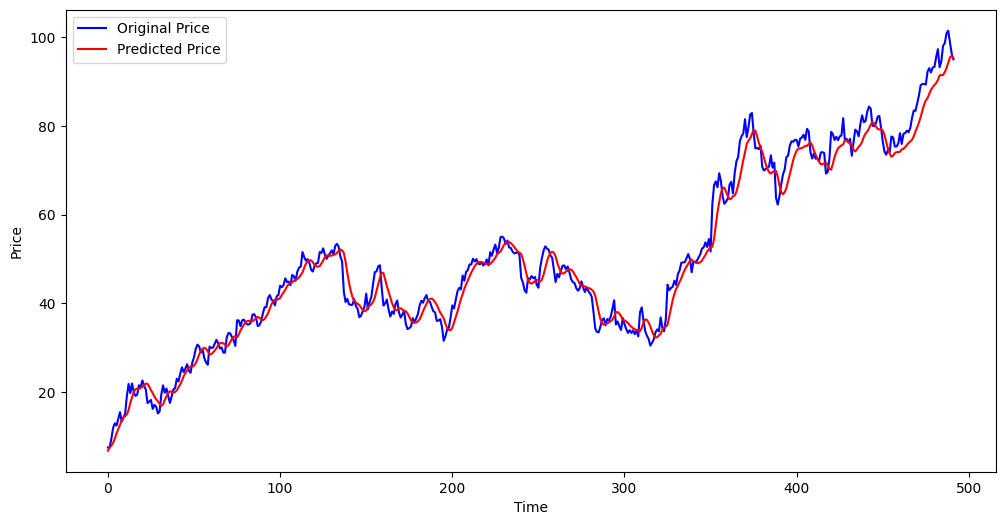

In [30]:
plt.figure(figsize = (12,6))
plt.plot(y_test, 'b', label = "Original Price")
plt.plot(y_pred, 'r', label = "Predicted Price")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Model evaluation

In [31]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print("Mean absolute error on test set: ", mae)

Mean absolute error on test set:  2.473456877314191


In [32]:
# 1) Install Java & Spark
!apt-get update -qq
!apt-get install -y openjdk-8-jdk-headless -qq
!wget -q https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar xf spark-3.3.2-bin-hadoop3.tgz -C /usr/local
!mv /usr/local/spark-3.3.2-bin-hadoop3 /usr/local/spark

# 2) Install Python deps
!pip install -q pyspark yfinance matplotlib scikit-learn findspark

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
^C


In [1]:
import os
# point to Java & Spark
os.environ["JAVA_HOME"]  = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/usr/local/spark"

import findspark
findspark.init()   # no args needed once SPARK_HOME is set

from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("AAPL_2020_2025_Forecast") \
    .getOrCreate()

print("✅ SparkSession started:", spark)


✅ SparkSession started: <pyspark.sql.session.SparkSession object at 0x7ae7341e4a90>


YF.download() has changed argument auto_adjust default to True


<ipython-input-2-86ed92bce95b>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(row["Open"]), float(row["High"]), float(row["Low"]),
<ipython-input-2-86ed92bce95b>:61: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(row["Volume"]), float(prev_close),
<ipython-input-2-86ed92bce95b>:62: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(last10.tail(5).mean()), float(last10.mean())
<ipython-input-2-86ed92bce95b>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(row["Open"]), float(row["High"]), float(row["Low"]),
<ipython-input-2-86ed92bce95b>:61: FutureWarning: Calling float on a s

100-Day Forecast (2025-01-01 → 2025-05-15)
RMSE = 7.3024, MAE = 5.4684, R² = 0.8219


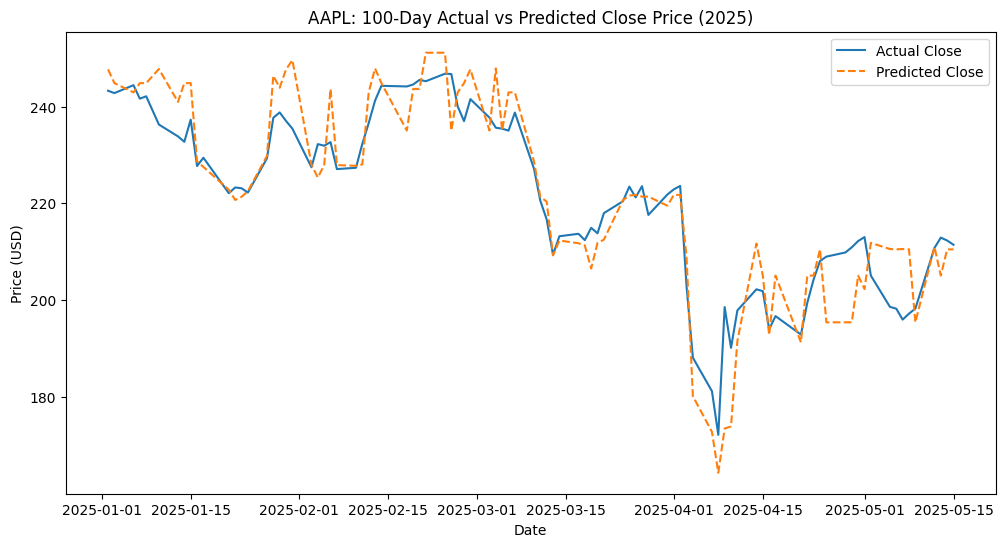

In [2]:

# ── Cell 3: Full pipeline + 100-day Forecast & Comparison ─────────

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from math import sqrt

from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col, to_date, lag, avg
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1) Download historical data into pandas & save CSV
hist_pdf = yf.download("AAPL", start="2020-01-01", end="2025-01-01", progress=False).reset_index()
hist_pdf = hist_pdf[["Date","Open","High","Low","Close","Volume"]]
hist_pdf.to_csv("/content/aapl_2020_2025.csv", index=False)

# 2) Load into Spark, cast columns, parse date
df = spark.read.option("header","true").csv("/content/aapl_2020_2025.csv")
for c in ["Open","High","Low","Close","Volume"]:
    df = df.withColumn(c, col(c).cast(DoubleType()))
df = df.withColumn("Date", to_date(col("Date"), "yyyy-MM-dd")).orderBy("Date")

# 3) Feature engineering
w = Window.orderBy("Date")
df_feat = (
    df
    .withColumn("PrevClose", lag("Close",1).over(w))
    .withColumn("MA5",       avg("Close").over(w.rowsBetween(-5, -1)))
    .withColumn("MA10",      avg("Close").over(w.rowsBetween(-10, -1)))
    .na.drop()
)

# 4) Train Gradient-Boosted Tree regressor
feature_cols = ["Open","High","Low","Volume","PrevClose","MA5","MA10"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
gbt = GBTRegressor(labelCol="Close", featuresCol="features", maxIter=100, maxDepth=5, seed=42)
pipeline = Pipeline(stages=[assembler, gbt])
model = pipeline.fit(df_feat)
gbt_model = model.stages[-1]  # the trained GBTRegressionModel

# 5) Download next 100 days of real data (pandas)
future_pdf = yf.download("AAPL", start="2025-01-01", end="2025-07-01", progress=False).reset_index()
future_pdf = future_pdf[["Date","Open","High","Low","Close","Volume"]].iloc[:100]
future_pdf["Date"] = pd.to_datetime(future_pdf["Date"])

# 6) One-step ahead forecasts (using actual O/H/L/V each day)
history = hist_pdf.copy().reset_index(drop=True)
preds = []
for _, row in future_pdf.iterrows():
    prev_close = history["Close"].iloc[-1]
    last10     = history["Close"].iloc[-10:]
    feats = [
        float(row["Open"]), float(row["High"]), float(row["Low"]),
        float(row["Volume"]), float(prev_close),
        float(last10.tail(5).mean()), float(last10.mean())
    ]
    vec  = Vectors.dense(feats)
    pred = gbt_model.predict(vec)
    preds.append(pred)
    # append the real row so MAs stay grounded
    history = pd.concat([history, pd.DataFrame([{
        "Date":   row["Date"],
        "Open":   row["Open"],
        "High":   row["High"],
        "Low":    row["Low"],
        "Close":  row["Close"],
        "Volume": row["Volume"]
    }])], ignore_index=True)


## ── 7) Compare & evaluate (flatten MultiIndex) ───────────────────
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 7a) Download 100 days into pandas
future_clean = yf.download("AAPL",
                           start="2025-01-01",
                           end="2025-07-01",
                           progress=False).reset_index()

# 7b) Flatten columns if they’re MultiIndex
if isinstance(future_clean.columns, pd.MultiIndex):
    future_clean.columns = future_clean.columns.get_level_values(0)

# 7c) Trim to the first 100 rows and only keep Date & Close
future_clean = future_clean[["Date","Close"]].iloc[:100]
future_clean["Date"] = pd.to_datetime(future_clean["Date"])

# 7d) Extract flat lists
dates      = future_clean["Date"].tolist()          # list of Timestamps
actuals    = future_clean["Close"].astype(float).tolist()  # list of floats
preds_list = [float(p) for p in preds]              # our preds list

# 7e) Build comparison DataFrame
rows = [{"Date": d, "Actual": a, "Predicted": p}
        for d, a, p in zip(dates, actuals, preds_list)]
comp = pd.DataFrame(rows).set_index("Date")

# 7f) Compute error metrics
rmse = sqrt(mean_squared_error(comp["Actual"], comp["Predicted"]))
mae  = mean_absolute_error(comp["Actual"], comp["Predicted"])
r2   = r2_score(comp["Actual"], comp["Predicted"])
print(f"100-Day Forecast (2025-01-01 → {comp.index.max().date()})")
print(f"RMSE = {rmse:.4f}, MAE = {mae:.4f}, R² = {r2:.4f}")

# 7g) Plot Actual vs Predicted
plt.figure(figsize=(12,6))
plt.plot(comp.index, comp["Actual"],    label="Actual Close")
plt.plot(comp.index, comp["Predicted"], "--",       label="Predicted Close")
plt.title("AAPL: 100-Day Actual vs Predicted Close Price (2025)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()